# Génération de profiles

On pose  les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma_{eff}}$$
$$\gamma = \frac{ \mu d_c}{H b \sigma_{eff}}$$

On trouve :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\bar{\Psi}[e^{\varphi}] - \gamma(\bar{v_m}-1)) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

Avec l'adimensionnement suivant : $$\bar \Psi = L_b \cdot \Psi$$

$$\Psi : v \mapsto \mathcal{K} * v$$

En définissant le noyau $\mathcal{K}$ par sa transformée de Fourier :

$$\mathcal{F}(\mathcal{K}) : k \mapsto |k| \frac{1+e^{-4|k|H}}{1-e^{-4|k|H}} = \frac{|k|}{\tanh(2|k|H)} $$

Et avec la contrainte normale effective suivante : $$\sigma_{eff} = \sigma - p(x,t)$$

Elle fait intervenir la contrainte constante due au poids des terrains $\sigma$ et un terme de pression de pore $p$ qui est sulution de l'équation de diffusion suivante :

$$\frac{\partial p}{\partial t} = D \frac{\partial^2 p}{\partial x^2} + 2 q D \delta_D(x)$$

Avec $D$ le coefficient de diffusion et $q$ le gradient de pression moyen imposé par l'injection. Une telle équation admet une solution analytique de la forme suivante :

$$p(x,t)=2q\sqrt{Dt} \Big[ |\xi| \big( erf(|\xi|)-1 \big) + \frac{e^{-\xi^2}}{\sqrt{\pi}} \Big]$$

En posant la variable de similitude $\xi$ suivante : $\xi = \frac{x}{2\sqrt{Dt}}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import special
from scipy import integrate
import pandas as pd

In [3]:
def noyau(freq,H) :
    pos = freq==0 #on localise la position des zéros
    freq[pos] = 1 #On remplace les zéros par des non-zéros (1 par exemple)
    c = np.abs(freq)
    freq = c/np.tanh(2*H*c) #on applique l'opération (sans rencontrer de zéros donc)
    freq[pos] = 0 #on met des zéros aux positions des zéros du tableau de départ
    return freq

def Psi(f, deltaX, H) :
    F=np.fft.fft(f)
    freq=np.fft.fftfreq(len(f),deltaX)*2*np.pi
    K = noyau(freq, H)
    F=K*F
    psi=np.fft.ifft(F)
    return psi.real*Lb

def F(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    den = v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(len(x)))
    phid1 = den/(alpha1 + beta*v)
    phid2 = den/(alpha2 + beta*v)
    phidot = np.concatenate((phid1[0:K1], phid2[K1:K2+1], phid1[K2+1:]))
    nudot = 1/theta - v
    return np.array([phidot, nudot])

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K + 1
        s = (tol / (2 * erreur))**0.25
        print(erreur)
        if erreur < tol:
            return ykk, s*h
        if s*h < dtmin:
            return ykk, h
        h = s*h
    if K==30 and erreur == tol:
        raise ValueError("Trop d'iterations")
    return ykk, h

def p(q, D, x, t):
    xi = np.abs(Lb*x/(2*np.sqrt(D*t*dc/v0)))
    return 2*q*np.sqrt(D*t*dc/v0)*(xi*(scipy.special.erf(xi)-1) + np.exp(-xi**2)/np.sqrt(np.pi))

In [4]:
##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400
D = 1e-6
q = 0

a1 = 2e-3
a2 = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

deltaX = int(Lb/4)
N = 4000
I = 2**8
L = I * deltaX
H = 2*L
h = 1e-2

d = L//20
K1 = (L//2-d)//deltaX
K2 = (L//2+d)//deltaX

alpha1 = a1/b 
alpha2 = a2/b

vseuil = 1e-2

x = np.arange(-L//2, L//2+1, deltaX)
xbar = x/Lb

# Génération de CI

In [ ]:
#Carré
A = []
for y in x :
    if y < d and y > -d:
        A.append(100)
    else :
        A.append(1)

A = np.array(A)
B = 1/A

In [ ]:
#Conditions initiales
NCI = 20000
CI = np.zeros(len(x))

tempsbar = np.array([1e-16])

yk = np.array([CI, CI])

Phi = CI
Nu = CI

for n in range(NCI):
    tbar = tempsbar[n]
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    tempsbar = np.concatenate((tempsbar, [tbar+h]))
    Phi = np.vstack((Phi,yk[0]))
    Nu = np.vstack((Nu,yk[1]))

In [ ]:
#Affichage du scénario
Mphi = np.array([np.max(f) for f in Phi])

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(tempsbar*dc/v0, Mphi, color='g')
ax.set_title('Maximum φ')
ax.set_xlabel('Time in s')
ax.set_ylabel('ln(v/v0)')
plt.grid()
plt.show()

In [ ]:
#Sélection des CI
temps = tempsbar*dc/v0
start = 0.73e8

debut = np.logical_and(temps>=start, temps <=start*(1+1e-2) )

df_phi = pd.DataFrame(data = Phi[debut, :][0])
df_phi.to_csv('CI_phi_profile.csv', index = False)

df_nu = pd.DataFrame(data = Nu[debut, :][0])
df_nu.to_csv('CI_nu_profile.csv', index = False)

# Vérification

In [ ]:
CI_phi = pd.read_csv('CI_phi_profile.csv')['0'].to_numpy()
CI_nu = pd.read_csv('CI_nu_profile.csv')['0'].to_numpy()

tempsbarv = np.array([1e-16])

ykv = np.array([CI_phi, CI_nu])

Mphiv = np.array([np.max(CI_phi)])

for n in range(N):
    tbarv = tempsbarv[n]
    res = RKF(F, ykv, hv)
    ykv = res[0]
    hv = res[1]
    tempsbar = np.concatenate((tempsbarv, [tbarv+hv]))
    Mphiv = np.concatenate((Mphiv, [np.max(ykv[0])]))

In [ ]:
#Affichage du scénario

fig, ax = plt.subplots()
ax.plot(tempsbarv*dc/v0, Mphiv, color='g')
ax.set_title('Maximum φ')
ax.set_xlabel('Time in s')
ax.set_ylabel('ln(v/v0)')
plt.grid()
plt.show()

# Génération de courbes

In [5]:
CI_phi = pd.read_csv('CI_phi_profile.csv')['0'].to_numpy()
CI_nu = pd.read_csv('CI_nu_profile.csv')['0'].to_numpy()

tempsbar = np.array([1e-16])
    
yk = np.array([CI_phi, CI_nu])

vnm1 = np.ones(len(x))
delta = np.zeros(len(x))
Delta = delta
Mphi = np.array([np.max(CI_phi)])
    
for n in range(N):
    tbar = tempsbar[n]
    pression = p(q,D,xbar,tbar)
    sigmaeff = sigma*np.ones(len(x)) - pression
    beta = eta*v0/(b*sigmaeff)
    gamma = mu*dc/(b*sigmaeff*H)
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    vn = np.exp(yk[0])
    delta = delta + h*(vn+vnm1)*dc/2
    vnm1 = vn
    Delta = np.vstack((Delta, delta))
    tempsbar = np.concatenate((tempsbar, [tbar+h]))
    Mphi = np.concatenate((Mphi, [np.max(yk[0])]))

temps = tempsbar*dc/v0

1.0291248302337357e-13
2.5110483731379796e-10
3.233534318164402e-11
5.911984675042921e-11
5.068788196016154e-11
5.2757854936434934e-11
5.2232268387464906e-11
5.2362972942550824e-11
5.2315392638195365e-11
5.230251437099003e-11
5.227494459642346e-11
5.224544870111564e-11
5.221372666314409e-11
5.217881800634557e-11
5.214542566739743e-11
5.211126578814978e-11
5.207890665034931e-11
5.204533376959841e-11
5.201578676268557e-11
5.198565275504455e-11
5.195907707241447e-11
5.193494531983718e-11
5.191051998070181e-11
5.1889472363949046e-11
5.187146049001218e-11
5.185576959473651e-11
5.184091863813534e-11
5.1828335482302124e-11
5.1820202024757065e-11
5.18107706868623e-11
5.1806792344881753e-11
5.1801939826223163e-11
5.180014083304751e-11
5.180051825349143e-11
5.180195465405092e-11
5.1804803102536015e-11
5.1808928814659006e-11
5.181499595452501e-11
5.182082227114484e-11
5.1829103449366665e-11
5.183663389822166e-11
5.1845977407497105e-11
5.185492919275879e-11
5.186432535244827e-11
5.1873202742438994

5.546885948155072e-11
5.549420020636551e-11
5.551769634282907e-11
5.554056370509515e-11
5.556706622881181e-11
5.559048369275365e-11
5.5614932792622525e-11
5.564149674642686e-11
5.566509787526756e-11
5.569058834408724e-11
5.571849314118149e-11
5.574163683690257e-11
5.576731603514918e-11
5.579615852076832e-11
5.581848569364159e-11
5.584787928493513e-11
5.587409866762368e-11
5.5899212197582506e-11
5.593046557892502e-11
5.5952782538403235e-11
5.598475730970997e-11
5.600485760438629e-11
5.604038441417564e-11
5.606392478429766e-11
5.6092989343266264e-11
5.612274192817755e-11
5.614838110634942e-11
5.6177986131741225e-11
5.620496695005584e-11
5.623680051538751e-11
5.6263349642333885e-11
5.629128618606221e-11
5.6322584534792523e-11
5.6346417119966234e-11
5.6382168753869884e-11
5.6403927913858025e-11
5.6435713958417264e-11
5.6468248404260727e-11
5.649311353620941e-11
5.652562711335479e-11
5.655040652888929e-11
5.658295779701365e-11
5.661153045392454e-11
5.6639561017231965e-11
5.666896683450085e-

5.357915804417948e-11
5.350956977821698e-11
5.3442638685274337e-11
5.337779985809849e-11
5.331139083857807e-11
5.3236541888211893e-11
5.3171298907010626e-11
5.3099843297217545e-11
5.3035357362711067e-11
5.2961351244765853e-11
5.289809514224754e-11
5.282651772581409e-11
5.276705578577186e-11
5.269506918671805e-11
5.263606389704369e-11
5.2573522357724185e-11
5.250584706100349e-11
5.245352128859985e-11
5.2389706708609814e-11
5.233298107710703e-11
5.2275204282123044e-11
5.222353065803052e-11
5.217071155755174e-11
5.211408767704837e-11
5.206413641160627e-11
5.201679023658048e-11
5.196610058705226e-11
5.192122354610077e-11
5.187906433695584e-11
5.1831012238099125e-11
5.17919012482182e-11
5.175173406906278e-11
5.171252878753421e-11
5.167662084865715e-11
5.16408855735068e-11
5.1609343033915005e-11
5.157767873457613e-11
5.155048913440136e-11
5.1523254116828655e-11
5.1500419102044535e-11
5.148138278702736e-11
5.1467357260212885e-11
5.1449373700274997e-11
5.1448195277882977e-11
5.143980557718385e

4.8248664764919974e-11
4.8235294374694765e-11
4.8230924607213695e-11
4.823424006171488e-11
4.822640154968497e-11
4.821586700386675e-11
4.822581491706341e-11
4.821024968663598e-11
4.820772572129088e-11
4.8212719199707017e-11
4.819975486561435e-11
4.820622091421154e-11
4.8200453137157004e-11
4.8199298985034385e-11
4.819171206160916e-11
4.8190375595877565e-11
4.819964680418468e-11
4.818729370418603e-11
4.8186373958109775e-11
4.8190711602904426e-11
4.818128149683177e-11
4.818947567458433e-11
4.8184577808685566e-11
4.8184844549577345e-11
4.81833205949194e-11
4.819235301145961e-11
4.8181891096535624e-11
4.8191764315733865e-11
4.8186258169889083e-11
4.8191398562209805e-11
4.819064971423389e-11
4.819444227310378e-11
4.819755542163862e-11
4.819842949702668e-11
4.820163022832376e-11
4.820280051670314e-11
4.820407402179711e-11
4.821044230929207e-11
4.820948534663643e-11
4.821632229471154e-11
4.8218380004185474e-11
4.8221843512525224e-11
4.8222168290298345e-11
4.8228227699097177e-11
4.823828847741

5.126209201950908e-11
4.999645120658197e-11
4.85458742325667e-11
4.691480664370257e-11
4.518898595004076e-11
4.3870997315000116e-11
4.4512357557317494e-11
4.9754976475399186e-11
5.9783959804838e-11
7.14340544399697e-11
7.56302730556452e-11
7.123356364259747e-11
6.639550361830937e-11
6.284438353644208e-11
6.023389580447929e-11
5.828898166049144e-11
5.675872951238375e-11
5.554416041965687e-11
5.4543272149658824e-11
5.3705847895483476e-11
5.2992797183747835e-11
5.238089934135021e-11
5.184040442656579e-11
5.137493032763268e-11
5.096000695394173e-11
5.058716873253924e-11
5.0259805557749553e-11
4.99675268078614e-11
4.970436263747596e-11
4.94714940818647e-11
4.926876719241453e-11
4.9075273296637526e-11
4.8926503692481665e-11
4.87822027847591e-11
4.867183487435133e-11
4.8583794777565726e-11
4.853658752260378e-11
4.852706088770856e-11
4.8575968325311414e-11
4.869880341029657e-11
4.88964129280227e-11
4.9194242447027525e-11
4.956403576839882e-11
4.9977395616865354e-11
5.0394562415482647e-11
5.075

4.870423153680779e-11
4.8489781367439627e-11
4.8283870418468234e-11
4.810137015502161e-11
4.792878960712201e-11
4.77725751002814e-11
4.763551101418176e-11
4.750144903973214e-11
4.737726885724205e-11
4.727048232059713e-11
4.716841408983181e-11
4.7087698378236534e-11
4.6995513530238793e-11
4.6930380242267695e-11
4.685985048145967e-11
4.680713120799524e-11
4.6757455767186e-11
4.6714841796163216e-11
4.667945993401193e-11
4.664850789889534e-11
4.662690368963463e-11
4.6606975192289164e-11
4.659763739054995e-11
4.658637721006501e-11
4.6589215516033035e-11
4.658475239806248e-11
4.6596717999280364e-11
4.660591598331693e-11
4.661201094100755e-11
4.663762235502473e-11
4.665147034451781e-11
4.667213536375909e-11
4.669515033178817e-11
4.6724793501893545e-11
4.6751490614129597e-11
4.677320184572508e-11
4.6811425445244543e-11
4.68403749169588e-11
4.686667933147993e-11
4.690705000104463e-11
4.6934140950185696e-11
4.697095649947679e-11
4.6998884867938833e-11
4.7035082547797806e-11
4.707065963069738e-11

5.1113231296260994e-11
5.103709526951255e-11
5.095355800684802e-11
5.088136886291578e-11
5.081478938756478e-11
5.075466218322584e-11
5.068893213766852e-11
5.064611235901925e-11
5.05897276376919e-11
5.0552966783503494e-11
5.050922192311207e-11
5.048162509274888e-11
5.046497488245882e-11
5.044908518608148e-11
5.0427510120924504e-11
5.042036781297958e-11
5.0425948104966855e-11
5.0411627358676486e-11
5.0427805434026114e-11
5.042052111327315e-11
5.043036696351041e-11
5.044063040060778e-11
5.043292098594355e-11
5.0439855110334503e-11
5.0423385155411276e-11
5.041585020346209e-11
5.040573644015615e-11
5.038294445414677e-11
5.0358895219893374e-11
5.032787688304609e-11
5.029169462288516e-11
5.024974669733014e-11
5.0204405288573216e-11
5.015287521061106e-11
5.010793605500199e-11
5.004870683415888e-11
4.999569335831027e-11
4.9929022949205456e-11
4.9871944038381726e-11
4.980171457678077e-11
4.974809660594783e-11
4.967896999846395e-11
4.9617942071393474e-11
4.954417664881382e-11
4.949833255237827e-1

5.15432398590992e-11
5.15843594376338e-11
5.1632049017740084e-11
5.167128727929533e-11
5.1697230248060916e-11
5.171668520251039e-11
5.176063400720795e-11
5.17537046196667e-11
5.1783144935647805e-11
5.1776783645912465e-11
5.178600315492375e-11
5.178699675536627e-11
5.1779975058916055e-11
5.1775293171143706e-11
5.1769018178882054e-11
5.174587337798214e-11
5.174022435730127e-11
5.1722780117967005e-11
5.17010126410378e-11
5.1687700757611035e-11
5.1661548122476214e-11
5.163565312834701e-11
5.161220346120882e-11
5.158679608314251e-11
5.156385945507369e-11
5.153253763227428e-11
5.150250519822253e-11
5.1471067011353803e-11
5.143965272198588e-11
5.140770822175824e-11
5.137548759241968e-11
5.1340999082635197e-11
5.130651945314997e-11
5.126793746905463e-11
5.123029852060311e-11
5.1190055986336876e-11
5.115821677726659e-11
5.110623222404166e-11
5.1074227769549726e-11
5.1021554202883565e-11
5.0980580577360086e-11
5.09357063449893e-11
5.0887716526911677e-11
5.083951689179427e-11
5.078405154644394e-1

4.7790639369276365e-11
4.779100857989316e-11
4.778650408970404e-11
4.778689708592106e-11
4.778143391650656e-11
4.778291716314183e-11
4.777747050060612e-11
4.7772969642266204e-11
4.776582671039836e-11
4.7768200785155606e-11
4.77596672070077e-11
4.775329252754654e-11
4.7744338498081763e-11
4.7736128935503263e-11
4.7735702033670576e-11
4.772052843218875e-11
4.77139224725138e-11
4.770257674544795e-11
4.7689021682568015e-11
4.767835478641761e-11
4.766734679664448e-11
4.765589202954929e-11
4.7636675036823176e-11
4.762582919436684e-11
4.7608292431988936e-11
4.7591777491164046e-11
4.757399097474058e-11
4.755303471470809e-11
4.7536832185847054e-11
4.751134681514491e-11
4.749097487098777e-11
4.7469947458546545e-11
4.7440443481732324e-11
4.742224838252844e-11
4.73851131420631e-11
4.736435879459114e-11
4.7328797091298816e-11
4.730498252110615e-11
4.726298903809861e-11
4.723187601047479e-11
4.719230752051565e-11
4.715927052919302e-11
4.711243948017615e-11
4.707227527174906e-11
4.7024222166592596e-1

4.738248922865122e-11
4.7320070702109734e-11
4.725698277399117e-11
4.7184190211736194e-11
4.7104687081819196e-11
4.702072583763265e-11
4.69305891614186e-11
4.682965440751331e-11
4.672131793817225e-11
4.66083315066919e-11
4.647527910876357e-11
4.6342218333273575e-11
4.619505889268735e-11
4.603593720033366e-11
4.587182754909051e-11
4.5702821761875926e-11
4.5537710922201236e-11
4.539179848880207e-11
4.5289141140042706e-11
4.527212636284492e-11
4.540054137551242e-11
4.5763100252197874e-11
4.642961944785435e-11
4.7417209885454195e-11
4.861274270204559e-11
4.977625663493704e-11
5.0691207467974795e-11
5.124902898466349e-11
5.1513083490754704e-11
5.156025463158681e-11
5.148637284218797e-11
5.135039071334157e-11
5.1185786028424566e-11
5.1015300289096945e-11
5.084710613593913e-11
5.06866978114713e-11
5.053728460717242e-11
5.039686085917612e-11
5.027217081717433e-11
5.014660470532735e-11
5.0044542877928745e-11
4.993253382970444e-11
4.9842921578228786e-11
4.975142028265189e-11
4.966515586400882e-1

4.705250639166574e-11
4.7023078504411425e-11
4.702041019798862e-11
4.704970583795343e-11
4.712358917190958e-11
4.7243079244996516e-11
4.743341070211634e-11
4.7686018257057227e-11
4.800355490872867e-11
4.837083631014216e-11
4.87695917785752e-11
4.9164918424808326e-11
4.952779900502482e-11
4.984075024797774e-11
5.0080176519894875e-11
5.0253404767024195e-11
5.036341900505028e-11
5.041998844985431e-11
5.043537851552313e-11
5.0412966972460085e-11
5.037492047547995e-11
5.031689639593368e-11
5.02484289243246e-11
5.0171426909089344e-11
5.009279139851231e-11
5.001108036788535e-11
4.9927524915334686e-11
4.984163958508283e-11
4.976201478815167e-11
4.967736442768149e-11
4.960030339353581e-11
4.9518192259534506e-11
4.9441631279571774e-11
4.93639482770352e-11
4.9287117276179426e-11
4.921294882291874e-11
4.9137335590999135e-11
4.906734292841336e-11
4.8991629410368626e-11
4.8922370060552466e-11
4.8849739232821734e-11
4.877667133039952e-11
4.870779502292464e-11
4.8632372935408785e-11
4.856582136516296e

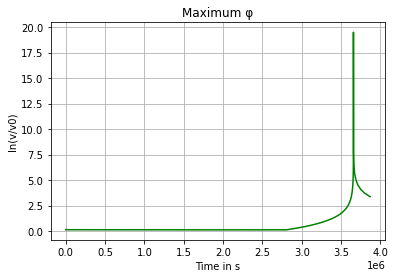

In [6]:
fig, ax = plt.subplots()
ax.plot(tempsbar*dc/v0, Mphi, color='g')
ax.set_title('Maximum φ')
ax.set_xlabel('Time in s')
ax.set_ylabel('ln(v/v0)')
plt.grid()
plt.show()

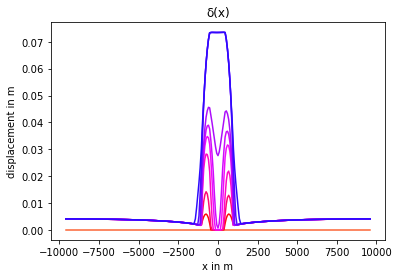

In [19]:
couleurs = ['#FC6232','#FF0909','#FF0972','#FF09C4','#F10CFC','#CE0CFC','#AC0DFB','#780AFE','#5509FF','#2D0AFE',
           '#0938FF','#0972FF']

pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, Delta[n], c=couleurs[n//pas])
plt.title('δ(x)')
plt.ylabel('displacement in m')
plt.xlabel('x in m')
plt.show()

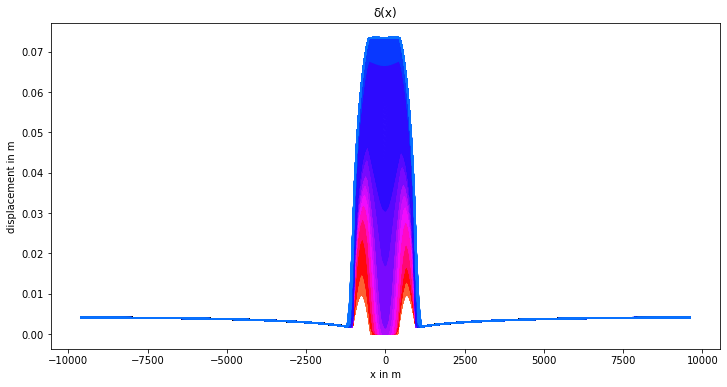

Kmax =2419


In [20]:
Kmax = 2419
K = 0

fig, ax = plt.subplots(figsize=(12,6))
for n in range(1, N+1):
    if (temps[n]-temps[n-1])<=0.2:
        ax.plot(x, Delta[n], c=couleurs[len(couleurs)*K//Kmax])
        K = K+1

ax.set_title('δ(x)')
ax.set_ylabel('displacement in m')
ax.set_xlabel('x in m')
plt.show()
print('Kmax ='+str(K))

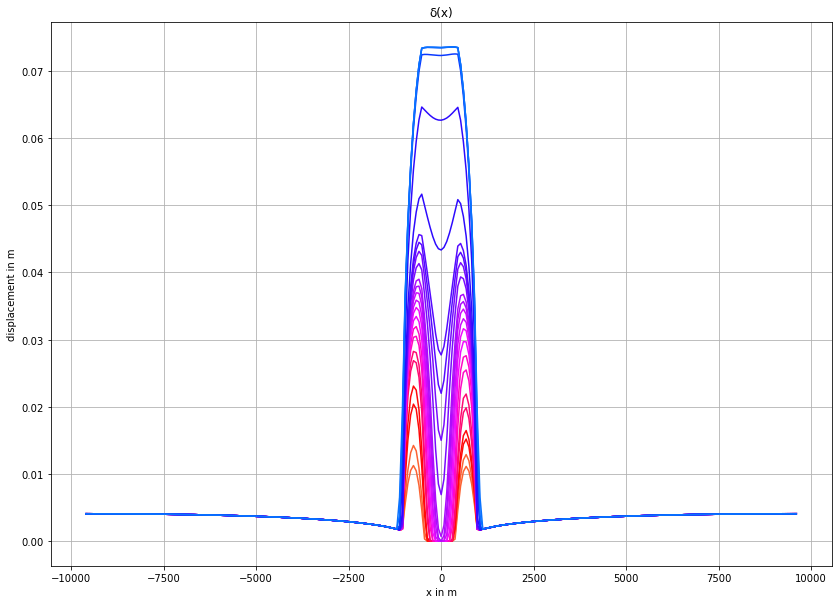

Kmax =2419


In [24]:
saut = 100 #nombre de courbes que l'on saute pour y voir clair
K = 0
Kc = 0

fig, ax = plt.subplots(figsize=(14,10))

for n in range(1, N+1):
    if (temps[n]-temps[n-1])<=0.2:
        K = K+1
        if Kc%saut==0:
            ax.plot(x, Delta[n], c=couleurs[len(couleurs)*K//Kmax])
    Kc = Kc+1

ax.set_title('δ(x)')
ax.set_ylabel('displacement in m')
ax.set_xlabel('x in m')
plt.grid()
plt.show()
print('Kmax ='+str(K))

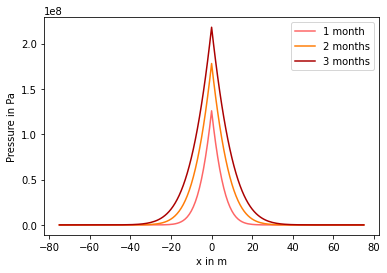

In [26]:
#Affichage d'un exemple pour la pression
q = 2e7
xbar = np.arange(-75, 76, 1)/Lb
tbar = np.array([24*60*60*30*12, 2*24*60*60*30*12, 3*24*60*60*30*12])*v0/dc

plt.plot(xbar*Lb, p(q, D, xbar, tbar[0]), color='#FE6666')
plt.plot(xbar*Lb, p(q, D, xbar, tbar[1]), color='#FF7E09')
plt.plot(xbar*Lb, p(q, D, xbar, tbar[2]), color='#AB0101')
plt.legend(['1 month', '2 months', '3 months'])
plt.xlabel('x in m')
plt.ylabel('Pressure in Pa')
plt.savefig('pressure.png')